# Phase shift between two signals using the wavelet cross-spectrum method 

## 1) Introduction

To determine the phase shift between two seismograms using the Wavelet cross-spectrum method, we tested the matlab wcoherence function on a simple example. We compute two signals which are composed of two sine functions (25 and 50 Hz) with white noise. For one of the signals, the 25 Hz sine function is delayed by $1\%$ of the time (e.g., $-0.01 \times t$, increasing delay) and the 50 Hz sine function is advanced by $+0.5\%$ of the time (e.g., $0.005 \times t$).


## 2) Test with sine functions
We first create a time vector *(t)* of 1 s with a sampling rate of 1000 Hz.<br>
We then create two signals *(x and y)*, which are composed of two sine functions with frequencies of 25 Hz and 50 Hz. Some noise is added to the two functions using _0.15*randn(1,length(t))_. <br>
The *(y)* function is shiffted by $-0.01 \times t$ for the 25 Hz sine wave (the time delay between the two functions constantly increase with time) and by $+0.005 \times t$ for the 50 Hz sine wave.

In [38]:
clear all
close all
clc

%Create time vector
delta = 1000;
t = linspace(0,1,delta);

% 2 Frequencies
nbosc = 25; % in Hz
shiftt = -.01; %(multiply by 100 for the time shift in percent)

nbosc2 = 50; % in Hz
shiftt2 = +.005; %(multiply by 100 for the time shift in percent)

% Noise level and amplitude of the sine functions
noise_level = .25; %(multiply by 100 for the noise level in percent)
amplitude = 0.5;

% Create sine functions
x = amplitude*(-sin(nbosc*2*pi*t) + noise_level*randn(1,length(t)) - sin(nbosc2*2*pi*t) + noise_level*randn(1,length(t)));
y = amplitude*(-sin(nbosc*2*pi*t + t*shiftt*2*pi*nbosc) + noise_level*randn(1,length(t)) -  sin(nbosc2*2*pi*t + t*shiftt2*2*pi*nbosc2) + noise_level*randn(1,length(t)));


Taper the first and last 0.0250 s (25 points for a 1000 Hz sampling rate) of the signals using a hanning function.

In [39]:
% Taper the end of the signals using a hanning window
 hann = hanning(50)';
 x(1:length(hann)/2) = x(1:length(hann)/2).*hann(1:length(hann)/2);
 y(1:length(hann)/2) = y(1:length(hann)/2).*hann(1:length(hann)/2);
 x(end-length(hann)/2:end) = x(end-length(hann)/2:end).*hann(length(hann)/2:end);
 y(end-length(hann)/2:end) = y(end-length(hann)/2:end).*hann(length(hann)/2:end);

 Compute the FFT of the x and y. Also compute the frequency vector *f1*.

In [40]:
fftx = abs(fft(x))./delta;
ffty = abs(fft(y))./delta;
df = 1/(length(x)/delta);
Ny = delta/2; % Nyquist frequency
f1 = 0:df:Ny-df; % frequency vector

Plot the time series (right) and their FFT amplitudes (left).

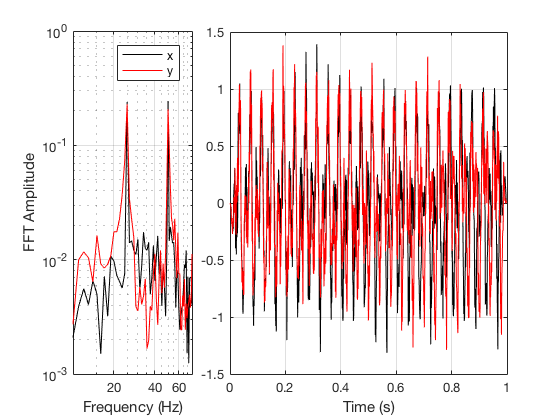

In [41]:
figure;
subplot(1, 3, 2:3)
plot(t, x, 'k')
hold on
plot(t, y, 'r')
xlabel('Time (s)')
grid on

subplot(1, 3, 1)
loglog(f1, fftx(1:end/2), 'k')
hold on
plot(f1, ffty(1:end/2), 'r')
xlabel('Frequency (Hz)')
ylabel('FFT Amplitude')
xlim([10 75])
legend('x', 'y')
grid on

Compute the wavelet coherence and cross-spectrum between x and y using the wcoherence function:
- wcoh: is the magnitude-squared wavelet coherence, which is a measure of the correlation between signals x and y in the time-frequency plane.
- wcs: Wavelet cross-spectrum, returned as a matrix of complex values.
- f: Frequency vector.
- coi: Cone of influence for the wavelet coherence, indicates where edge effects occur in the coherence data.

To obtain the phase information of the wavelet cross-spectrum from wcs, we compute get the imagiry part of the signal using $angle(wcs)$. The value is then divided by $2\times \pi \times f$ to retrieve the true time shift in second for each frequency.

In [42]:
[wcoh,wcs,f,coi] = wcoherence( y, x, delta);
ang2 = angle(wcs)./(f*2*pi); % Phase information in second for each frequency

Plot time series (top), the magnitude-squared wavelet coherence (middle), and the phase information of the wavelet cross-spectrum (bottom). The COI is shown by the black lines and only the values inside the COI can be trusted. Note that the magnitude-squared wavelet coherence is maximum (e.g., close to one) for the 25 and 50 Hz frequencies in the middle plot. For the phase information, the phase lag is positive (red) for the 50 Hz frequency and negative (blue) for the 25 Hz frequency.

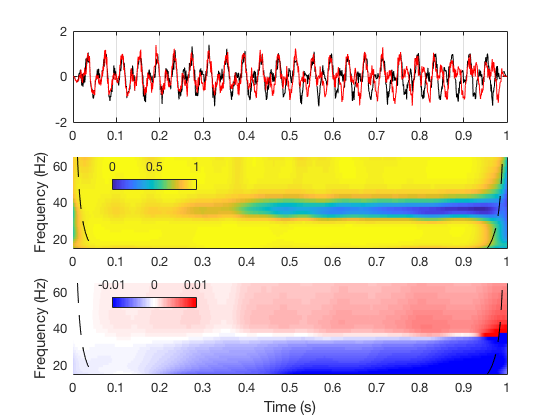

In [43]:
figure;
%Plot time series
subplot(3,1,1)
plot(t, x, 'k')
hold on
plot(t, y, 'r')
grid on

% Plot magnitude-squared wavelet coherence 
subplot(3, 1, 2)
h = surf(t, f, wcoh);
set(h, 'LineStyle', 'none')
view(0,90)
ylim([15 65])
ylabel('Frequency (Hz)')
hold on
zf = ones(1, length(t))*100;
plot3(t,(coi), zf,'k--');
c = colorbar('location', 'north');
set(c,'position', [0.2  0.55  0.15  0.0234]);
caxis([0 1])
box on

% Plot phase 
subplot(3, 1, 3)
h = surf(t, f, ang2);
hold on
view(0,90)
set(h, 'LineStyle', 'none')
colormap(gca,redblue)
c = colorbar('location', 'north');
set(c,'position', [0.2  0.27  0.15  0.0234]);
caxis([-0.01 .01])
ylim([15 65])
plot3(t,(coi),zf,'k--');
xlabel('Time (s)')
ylabel('Frequency (Hz)')
box on

Get the time delay ($-0.01 \times t$) of the y function from the wcoherence phase.<br>
We first find the closest frequencies to 25 and 50 Hz in the f variable.<br>
For the two frequencies (*f(b)*), we select the phase values through time and fit them with a linear function (straight line). The slope of this function corresponds to the delay through time (constant here for the two frequencies). Note that we do not include the first and last $0.1$ s values as they are close to or outside the cone of influence (COI).<br>

The fitting allows us to retrieve the true time shift (or dv/v) for the 25 and 50 Hz.

In [44]:
for i =1:2
    if i ==1
        nboscf = nbosc2;
    else
        nboscf = nbosc;
    end

    [~,b(i)] =min(abs(f-nboscf));
    val = .1 *delta;
    mdl =fitlm(t(val:end-val),ang2(b(i),val:end-val));
    slope(i,:)= mdl.Coefficients.Estimate(2);
end


Finally plot the values. 
Note that the value of the slope is the same (or very similar depending on the noise added to the sine functions) as the true value for the two frequency of interest (e.g., -0.01 (-1%) for 25 Hz and +0.005 (+0.5%) for 50 Hz).

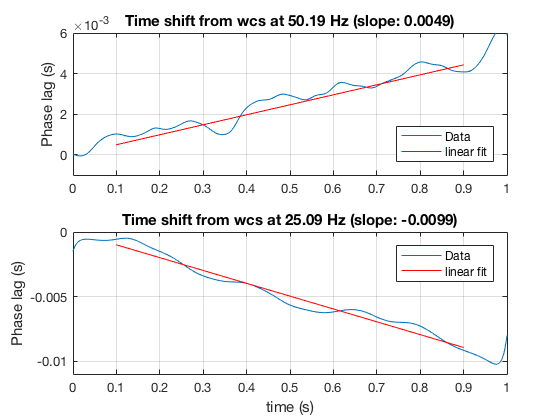

In [49]:
figure ;
for i =1:2
subplot(2,1,i)
plot(t, ang2(b(i),:))
hold on 
plot(t(val:end-val),t(val:end-val)*slope(i), 'r')
title(['Time shift from wcs at ' num2str(round(f(b(i)),2)) ' Hz (slope: ' num2str(round(slope(i),4)) ')'])
grid on
if i ==1
ylim([-.001 .006])
legend('Data', 'linear fit', 'location', 'southeast')
else
ylim([-.011 0])
legend('Data', 'linear fit', 'location', 'northeast')
xlabel('time (s)')
end
ylabel('Phase lag (s)')
end
